In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("/home/bhavya/Downloads/datasets/QVI_transaction_data.csv")
df.sample(5)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
231495,43310,79,79337,78168,112,Tyrrells Crisps Ched & Chives 165g,2,8.4
193035,43380,109,109183,111265,80,Natural ChipCo Sea Salt & Vinegr 175g,2,6.0
81058,43332,166,166260,168295,2,Cobs Popd Sour Crm &Chives Chips 110g,2,7.6
125167,43503,110,110261,113129,12,Natural Chip Co Tmato Hrb&Spce 175g,2,6.0
4757,43586,256,256185,255331,23,Cheezels Cheese 330g,2,11.4


In [3]:
df.shape
df.drop_duplicates(inplace = True)
# running this code shows that there was only 1 duplicate row: df.shape

In [4]:
df.info()
# pd.isnull(df).sum() 
# as per above code there were no null values in this data

<class 'pandas.core.frame.DataFrame'>
Index: 264835 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264835 non-null  int64  
 1   STORE_NBR       264835 non-null  int64  
 2   LYLTY_CARD_NBR  264835 non-null  int64  
 3   TXN_ID          264835 non-null  int64  
 4   PROD_NBR        264835 non-null  int64  
 5   PROD_NAME       264835 non-null  object 
 6   PROD_QTY        264835 non-null  int64  
 7   TOT_SALES       264835 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 18.2+ MB


In [5]:
df = df.rename(columns = {'STORE_NBR' : 'STORE_NO', 'LYLTY_CARD_NBR' : 'LOYALTY_CARD', 'PROD_NBR' : 'PROD_NO', 'PROD_NAME' : 'PRODUCT', 'PROD_QTY': 'QUANTITY', 'TOT_SALES' : 'TOTAL_SALES'})
df.head()

,DATE,STORE_NO,LOYALTY_CARD,TXN_ID,PROD_NO,PRODUCT,QUANTITY,TOTAL_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [6]:
df.drop(columns=['DATE'], inplace=True)
# dropping this column entirely because changing its data type to 'date time' made the values become NaT (Not a Time)
# and hence it seems that the data in this column is likely corrupt or meaningless.

In [7]:
#  Extracting the weight using a regular expression
df['WEIGHT_in_gm'] = df['PRODUCT'].str.extract(r'(\d+\.?\d*\s*[kK]?[gG]?)')

# Remove the weight from the product name
df['PRODUCT'] = df['PRODUCT'].str.replace(r'\s*\d+\.?\d*\s*[kK]?[gG]?', '', regex=True)


# now converting weight column from object to int64 data type
# Step 1: Remove non-numeric characters (e.g., 'g', 'kg')
df['WEIGHT_in_gm'] = df['WEIGHT_in_gm'].str.replace(r'[^0-9.]', '', regex=True)

# Step 2: Convert to numeric (float first, then int)
df['WEIGHT_in_gm'] = pd.to_numeric(df['WEIGHT_in_gm'], errors='coerce')  # Convert to float
df['WEIGHT_in_gm'] = df['WEIGHT_in_gm'].astype('Int64')  # Convert to integer (nullable integer type)


df.head()

,STORE_NO,LOYALTY_CARD,TXN_ID,PROD_NO,PRODUCT,QUANTITY,TOTAL_SALES,WEIGHT_in_gm
0,1,1000,1,5,Natural Chip Compny SeaSalt,2,6.0,175
1,1,1307,348,66,CCs Nacho Cheese,3,6.3,175
2,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170
3,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion,5,15.0,175
4,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili,3,13.8,150


# identifying the top 10 most profitable products:

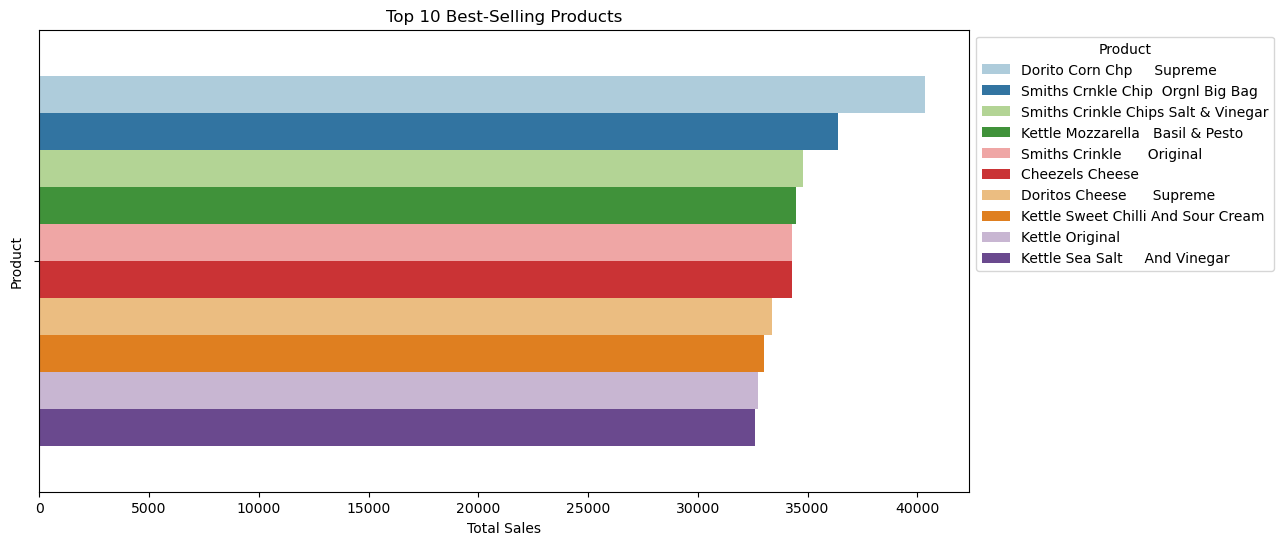

In [8]:
# Aggregate total sales per product
top_products = df.groupby("PRODUCT")["TOTAL_SALES"].sum().nlargest(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, hue=top_products.index, palette="Paired")
plt.xlabel("Total Sales")
plt.ylabel("Product")
plt.legend(title = 'Product', bbox_to_anchor=(1.0, 1), loc="upper left")
plt.title("Top 10 Best-Selling Products")
plt.show()

# finding patterns in bulk buying behavior:

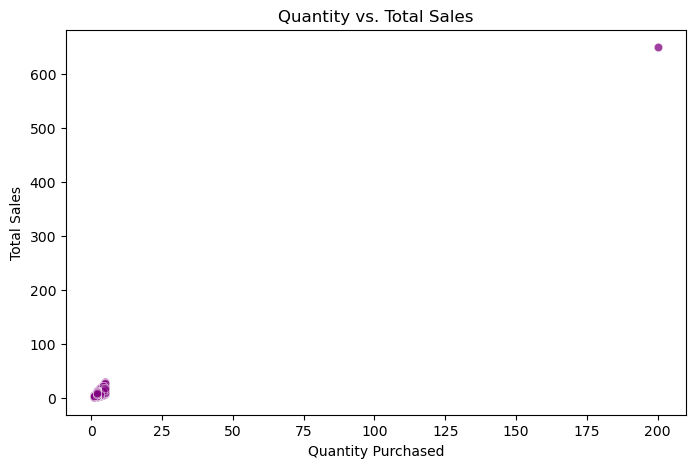

In [9]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="QUANTITY", y="TOTAL_SALES", alpha=0.5, color="purple")
plt.xlabel("Quantity Purchased")
plt.ylabel("Total Sales")
plt.title("Quantity vs. Total Sales")
plt.show()

Here we see that bulk buying of chips happens very less frequently and usually chips' packets are bought in single digit numbers in one purchase.

# now calculating Top 10 heaviest chips packets:

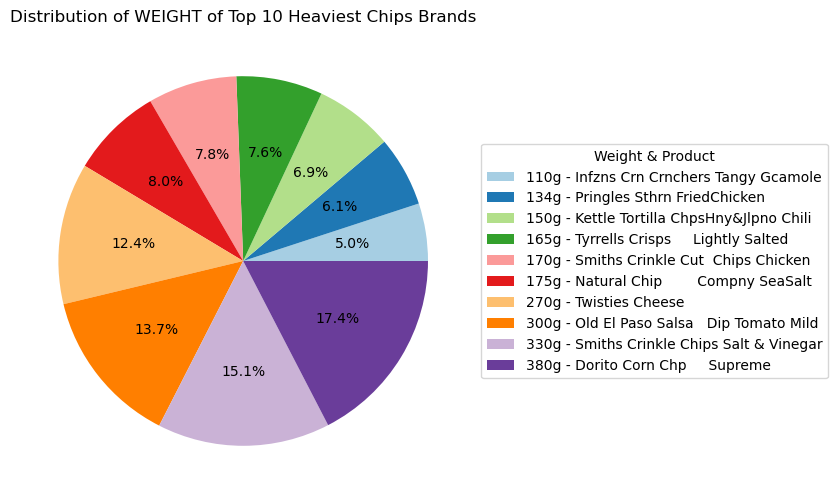

In [22]:
# calculating Top 10 heaviest chips packets:
top_weights = df.groupby("WEIGHT_in_gm")["PRODUCT"].first().loc[df["WEIGHT_in_gm"].value_counts().nlargest(10).index]

# Sort by weight (ascending order)
top_weights = top_weights.sort_index()

# Creating the Pie Chart with Correct Proportions
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(top_weights.index, labels=None, colors=plt.cm.Paired.colors, autopct='%1.1f%%')

# Formatting the legend with both weight & product names
legend_labels = [f"{weight}g - {product}" for weight, product in zip(top_weights.index, top_weights.values)]
plt.legend(wedges, legend_labels, title="Weight & Product", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Distribution of WEIGHT of Top 10 Heaviest Chips Brands")
plt.show()

# finding out Top 10 Lightest Chips Brands via another visualization

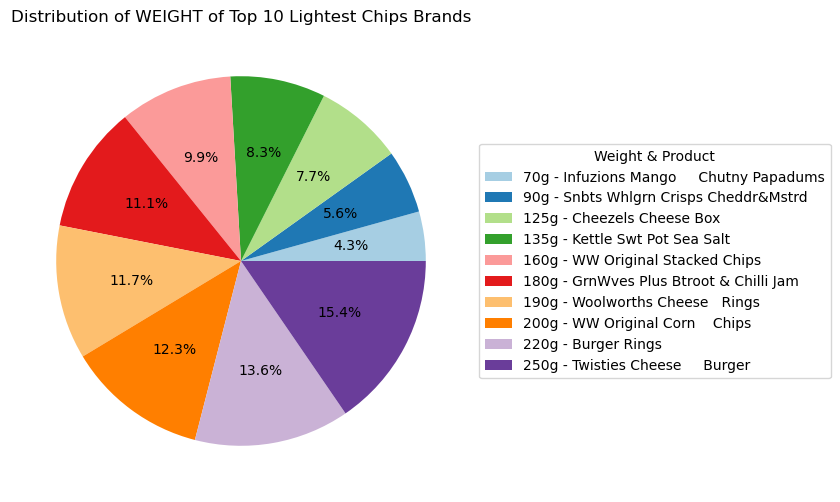

In [23]:
# Calculating Top 10 Lightest Chips Packets:
lightest_weights = df.groupby("WEIGHT_in_gm")["PRODUCT"].first().loc[df["WEIGHT_in_gm"].value_counts().nsmallest(10).index]

# Sort by weight (ascending order)
lightest_weights = lightest_weights.sort_index()

# Creating the Pie Chart with Correct Proportions
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(lightest_weights.index, labels=None, colors=plt.cm.Paired.colors, autopct='%1.1f%%')

# Formatting the legend with both weight & product names
legend_labels = [f"{weight}g - {product}" for weight, product in zip(lightest_weights.index, lightest_weights.values)]
plt.legend(wedges, legend_labels, title="Weight & Product", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Distribution of WEIGHT of Top 10 Lightest Chips Brands")
plt.show()

# Analyzing the second dataset.

In [34]:
df2 = pd.read_csv("/home/bhavya/Downloads/datasets/QVI_purchase_behaviour.csv")
df2.sample(5)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
1204,4182,YOUNG SINGLES/COUPLES,Mainstream
64106,240186,RETIREES,Mainstream
43835,165243,YOUNG SINGLES/COUPLES,Mainstream
6818,24226,OLDER SINGLES/COUPLES,Budget
10102,37135,OLDER FAMILIES,Premium


In [35]:
df2 = df2.rename(columns = {'LYLTY_CARD_NBR':'LOYALTY_CARD'})
df2.head()

,LOYALTY_CARD,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [36]:
df2.shape

(72637, 3)

In [37]:
df2.info()
# pd.isnull(df2).sum() 
# no null values in this dataset either!

# no duplicate values were found
# df2.drop_duplicates(inplace = True)
# df2.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LOYALTY_CARD      72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [38]:
df2['PREMIUM_CUSTOMER'].value_counts()

PREMIUM_CUSTOMER
Mainstream    29245
Budget        24470
Premium       18922
Name: count, dtype: int64

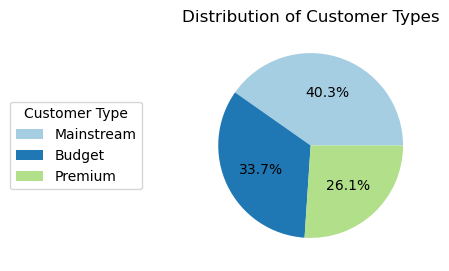

In [39]:
# Value counts for PREMIUM_CUSTOMER
premium_counts = {"Mainstream": 29245, "Budget": 24470, "Premium": 18922}
# Creating the Pie Chart
plt.figure(figsize=(3,3))
wedges, texts, autotexts = plt.pie(premium_counts.values(), labels=None, colors=plt.cm.Paired.colors, autopct='%1.1f%%')

# Adding legend
plt.legend(wedges, premium_counts.keys(), title="Customer Type", loc="center right", bbox_to_anchor=(-0.2, 0.5))
plt.title("Distribution of Customer Types")
plt.show()

In [40]:
df2['LIFESTAGE'].value_counts()

LIFESTAGE
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: count, dtype: int64

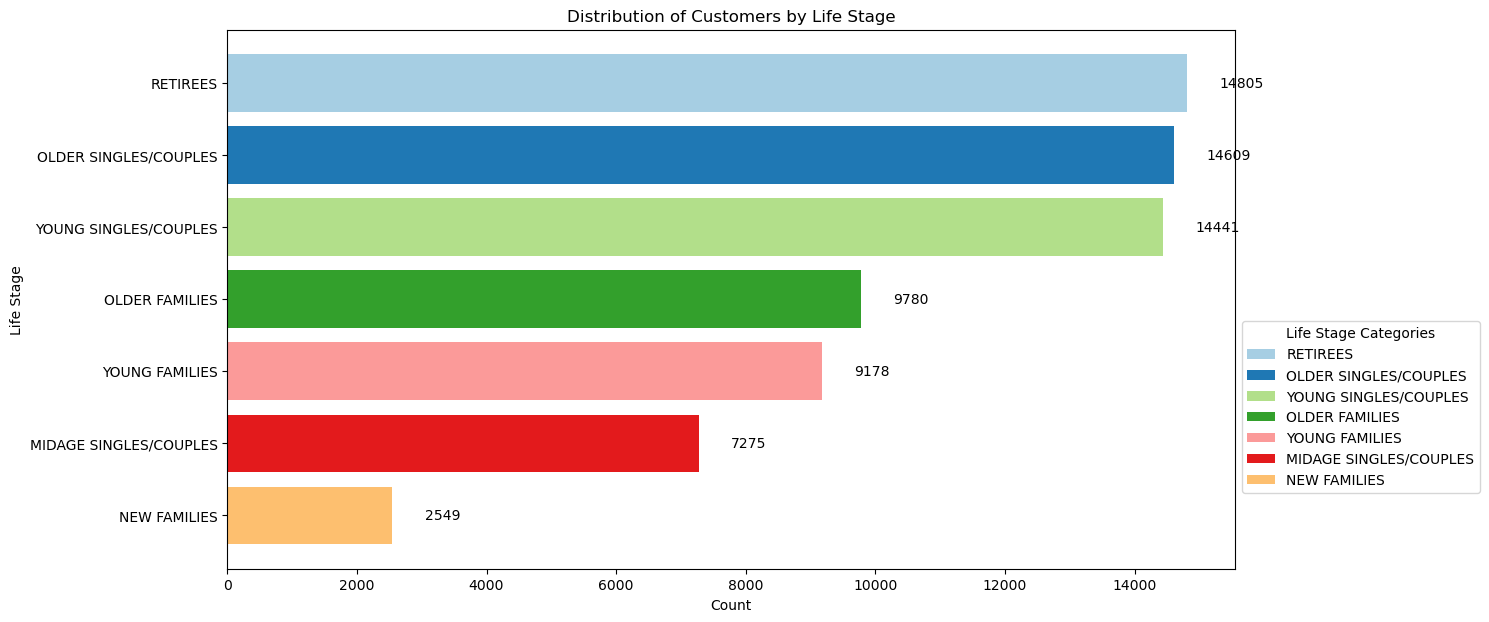

In [59]:
# LIFESTAGE value counts
lifestage_counts = {
    "RETIREES": 14805,
    "OLDER SINGLES/COUPLES": 14609,
    "YOUNG SINGLES/COUPLES": 14441,
    "OLDER FAMILIES": 9780,
    "YOUNG FAMILIES": 9178,
    "MIDAGE SINGLES/COUPLES": 7275,
    "NEW FAMILIES": 2549
}

# Extracting labels and values
labels = list(lifestage_counts.keys())
values = list(lifestage_counts.values())

# Creating a horizontal bar chart
plt.figure(figsize=(13, 7))
bars = plt.barh(labels, values, color=plt.cm.Paired.colors)

# Adding value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2, f"{value}", va='center')

# Add legend
plt.legend(bars, labels, title="Life Stage Categories", loc="center left", bbox_to_anchor=(1, 0.3))

# Title and labels
plt.xlabel("Count")
plt.ylabel("Life Stage")
plt.title("Distribution of Customers by Life Stage")

plt.gca().invert_yaxis()  # Invert y-axis so highest count is on top
plt.show()